<h1 style="text-align: center;" markdown="1"> Generate a Dataset with Pandas </h1>

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib
import pandas as pd
matplotlib.use('agg')
import matplotlib.pyplot as plt
import random
import re

from sklearn import model_selection

In [3]:
from stop_words import get_stop_words

In [3]:
ROOT_PATH='/home/asr/prj_SlotTagger/dnn_train'

In [11]:
ROOT_PATH=os.getcwd()

### Counting Elements

In [44]:
%%time

num_lines_num  = sum(1 for line in open(ROOT_PATH + '/data/sei_6/num/sei_num'))
num_lines_ver  = sum(1 for line in open(ROOT_PATH + '/data/sei_6/ver/sei_verb'))

ratio = num_lines_num  / float(num_lines_ver) 
print('Corpus_six_num: %d, Corpus_six_ver: %d, Ratio: %0.3f' %(num_lines_num, num_lines_ver, ratio)) 

Corpus_six_num: 103484, Corpus_six_ver: 285704, Ratio: 0.362
CPU times: user 137 ms, sys: 12.8 ms, total: 150 ms
Wall time: 154 ms


### Building the Data-Frame (Balanced)

In [45]:
def load_dataset(directory_1, directory_2):
    # NOTE: Put in directory_2 the largest corpus
    data = {}
    data["sentence"] = []
    data["class"] = []
    l1 = 0
    for file_path in os.listdir(directory_1):
        with tf.gfile.GFile(os.path.join(directory_1 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines()]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(1)
    
    for file_path in os.listdir(directory_2):
        with tf.gfile.GFile(os.path.join(directory_2 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines() if np.random.random() <= ratio]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(0)

    return pd.DataFrame.from_dict(data)

In [46]:
%%time
directory_1 = ROOT_PATH + '/data/sei_6/num/'
directory_2 = ROOT_PATH + '/data/sei_6/ver/'

dataset_df = load_dataset(directory_1, directory_2)

CPU times: user 2.12 s, sys: 97.2 ms, total: 2.21 s
Wall time: 2.5 s


### Some Checks

In [47]:
# Check Balanced
dataset_df.groupby('class').count()

,sentence
class,
0,103697
1,103484


In [48]:
# Print some samples
for i in range(10):
    print(dataset_df.iloc[i]['sentence'])
    print(dataset_df.iloc[-i -1]['sentence'])

a al comma dopo le parole inferiore a sei
whoa whoa whoa sei cifre
a anni accoltellò all'addome jimmy davis un bambino di sei anni e lo nascose nei
usati in un codice con sei cifre
a anni da del mondo e con l'uscita al primo turno da sei slam
tuttavia sono sei cifre
a anni e sei mesi dalla
si dispone di un reddito di sei cifre
a anni passa nelle giovanili del milan dove trascorre sei stagioni laureandosi per due volte
sei cifre solo per cominciare
a a sei
sei cifre quello che mi serve
a a sei minuti dal
sei cifre non mi serviva altro
aa vv sei secoli di musica nel duomo
sei cifre facili
a balaustra e sei gruppi di scalini che su ambedue i lati conducono verso la città
sei cifre come il codice a barre che potrebbe essere l algoritmo magico
a baltimora nel maryland il più giovane di sei figli
secondo sotto la mia gestione ogni accordo che supera le sei cifre deve essere solennemente commemorato


In [49]:
dataset_df.head(5)

,sentence,class
0,a al comma dopo le parole inferiore a sei,1
1,a anni accoltellò all'addome jimmy davis un ba...,1
2,a anni da del mondo e con l'uscita al primo tu...,1
3,a anni e sei mesi dalla,1
4,a anni passa nelle giovanili del milan dove tr...,1


In [50]:
dataset_df.tail(5)

,sentence,class
207176,sei cifre solo per cominciare,0
207177,si dispone di un reddito di sei cifre,0
207178,tuttavia sono sei cifre,0
207179,usati in un codice con sei cifre,0
207180,whoa whoa whoa sei cifre,0


### Statistics about the dataset

In [33]:
# Counting number of words and mean
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).mean()

sentence    8.396056
class       1.000000
dtype: float64

In [34]:
# Max length sentence
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).max()

sentence    22
class        1
dtype: int64

In [35]:
# Max length sentence
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).std()

sentence    3.600541
class       0.000000
dtype: float64

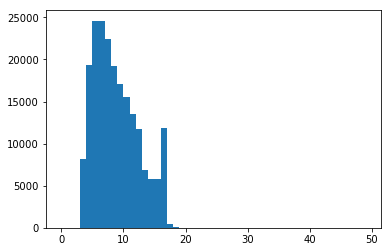

In [36]:
# Histogram of the lengths
%matplotlib inline

length_sentence = dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1)
plt.hist(length_sentence['sentence'],bins=range(50))
plt.show()

### Shuffle the Dataset

In [78]:
index = [i for i in range(dataset_df.shape[0])]
random.shuffle(index)
dataset = dataset_df.set_index([index]).sort_index()

dataset.head(10)

,sentence,class
0,non hai una vacanza da sei anni cal andiamo,1
1,mi ricordi i miei impegni del sei agosto prossimo,1
2,ti sei ehm,0
3,dice di aspettarlo alla stazione stasera alle sei,1
4,accoppiato un cambio automatico a sei,1
5,nei primi sei mesi di quest'anno sbb cff ffs c...,1
6,da quando sei tornata in scozia hai cercato di...,0
7,dai trent tu sei meglio di così,0
8,di sei mesi del,1
9,se ogni sei mesi il ministro delle,1


### Some other cleaning...

In [79]:
exclude1 = ['\t', '"', '?'] # list
exclude2 = ["'", "  ", "   ", "    ", "     "] # list

def clean_text(text):
    for c in exclude1:
        text=text.replace(c,'')
    for c in exclude2:
        text=text.replace(c, " ")
    return text.lower().strip()

sentence_processed = list(map(clean_text, dataset['sentence'].values))

dataset['sentence'] = sentence_processed

dataset.head(10)

,sentence,class
0,non hai una vacanza da sei anni cal andiamo,1
1,mi ricordi i miei impegni del sei agosto prossimo,1
2,ti sei ehm,0
3,dice di aspettarlo alla stazione stasera alle sei,1
4,accoppiato un cambio automatico a sei,1
5,nei primi sei mesi di quest anno sbb cff ffs c...,1
6,da quando sei tornata in scozia hai cercato di...,0
7,dai trent tu sei meglio di così,0
8,di sei mesi del,1
9,se ogni sei mesi il ministro delle,1


### Lemmatization using Spacy

In [54]:
import spacy 

nlp = spacy.load('en_core_web_sm')

In [80]:
%%time 

def lemmatizer(text):
    doc = nlp(text)
    lemmatizer = [token.lemma_ for token in doc]
    return ' '.join(lemmatizer)

sentence_processed = list(map(lemmatizer, dataset['sentence'].head(1000).values))

#dataset['sentence'] = sentence_processed

#dataset.head(10)

CPU times: user 22.6 s, sys: 3.34 s, total: 26 s
Wall time: 13.3 s


In [82]:
(200000/1000)*13.3 / 60.0

44.333333333333336

## Split for Tagger Classifier (Train, Valid)

In [41]:

splitter =  model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=19850610)

splits = list(splitter.split(X=dataset['sentence'], y=dataset['class']))
train_index = splits[0][0]
valid_index = splits[0][1]

train_df = dataset.loc[train_index,:]
print('Training-Set size: %d' %len(train_df))

valid_df = dataset.loc[valid_index,:]
print('Validation-Set size: %d' %len(valid_df))

Training-Set size: 176064
Validation-Set size: 31071


In [42]:
print("Training Set")
training_value_counts = train_df['class'].value_counts()
print(training_value_counts)
print("class 0 %: {}".format(round(training_value_counts[0]/len(train_df)*100,2)))
print("class 1 %: {}".format(round(training_value_counts[1]/len(train_df)*100,2)))
print("")
print("Validation Set")
validation_value_counts = valid_df['class'].value_counts()
print(validation_value_counts)
print("class 0 %: {}".format(round(validation_value_counts[0]/len(valid_df)*100,2)))
print("class 1 %: {}".format(round(validation_value_counts[1]/len(valid_df)*100,2)))

Training Set
0    88103
1    87961
Name: class, dtype: int64
class 0 %: 50.04
class 1 %: 49.96

Validation Set
0    15548
1    15523
Name: class, dtype: int64
class 0 %: 50.04
class 1 %: 49.96


In [43]:
train_df.to_csv(os.path.join(ROOT_PATH, 'tsvfiles/train_data.tsv'), header=False, index=False, sep='\t')
valid_df.to_csv(os.path.join(ROOT_PATH, 'tsvfiles/valid_data.tsv'), header=False, index=False, sep='\t')

## Calculate Vocabulary and Save it

In [20]:
stop_words = get_stop_words('italian') + get_stop_words('english')

my_stop_words = []
for my_word in my_stop_words:
    stop_words.append(my_word)
    
# Important step for this dataset!!!!
stop_words.remove('sei')

In [82]:
ww = ['criks', 'crjis3','cr456is', '45crist','1v','f4','16','l','9','5ffff56566778','cv', 'ai']

falseIfDigit = lambda word: not bool((re.match('^(?=.*[0-9])', str(word))))

[w for w in ww if (falseIfDigit(w) or w.isdigit()) and (len(w) > 1 or w.isdigit()) ]

['criks', '16', '9', 'cv', 'ai']

In [27]:

# This function returns FALSE if there is a digit in the string (i.e '4mmm', 'm44m', 'llp4')
#falseIfDigit = lambda word: not bool((re.match('^(?=.*[0-9])', str(word))))

def get_vocab():
    #allWords = []
    vocab = set()
    for text in train_df['sentence'].values:
        words = text.split(' ')
        # remove digits
        words_only = [w for w in words if not w.isdigit()]
        # exclude words shorter than 2, but not numbers. exclude words with numbers inside, i.e. '3cris', 'c45ris', 'cris23'
        #words_ = [w for w in words_only if (falseIfDigit(w) or w.isdigit()) and (len(w) > 1 or w.isdigit()) ]
        words_ = [w for w in words_only if len(w) > 0 ]
        #words_ = words_only
        #allWords = allWords + words_
        word_set = set(words_)
        vocab.update(word_set)
    
    #vocab.remove('')
    return list(vocab)#, allWords

def get_all_words():
    allWords = []
    cnt = 0
    for text in train_df['sentence'].values:
        words = text.split(' ')
        # remove digits
        words_only = [w for w in words if not w.isdigit()]
        # exclude words shorter than 2, but not numbers. exclude words with numbers inside, i.e. '3cris', 'c45ris', 'cris23'
        #words_ = [w for w in words_only if (falseIfDigit(w) or w.isdigit()) and (len(w) > 1 or w.isdigit()) ]
        words_ = [w for w in words_only if len(w) > 0 ]
        #words_ = words_only
        allWords = allWords + words_
        #word_set = set(words_)
        cnt += 1
        if cnt%10000==0:
            print('-----------', cnt)
    
    return allWords



In [28]:
%%time
vocab = get_vocab()
print('--------------------', len(vocab))


-------------------- 64006
CPU times: user 820 ms, sys: 2 µs, total: 820 ms
Wall time: 820 ms


In [29]:
'ci' in vocab

True

In [30]:
%%time
allWords = get_all_words()
print('--------------------', len(allWords))

----------- 10000
----------- 20000
----------- 30000
----------- 40000
----------- 50000
----------- 60000
----------- 70000
----------- 80000
----------- 90000
----------- 100000
----------- 110000
----------- 120000
----------- 130000
----------- 140000
----------- 150000
----------- 160000
----------- 170000
-------------------- 1522514
CPU times: user 44min 42s, sys: 596 ms, total: 44min 43s
Wall time: 44min 44s


In [31]:
from collections import Counter
cnt_allWords = Counter(allWords)

In [32]:
vocab_words_sorted_by_appearence = sorted(cnt_allWords.items(), key=lambda kv: len(vocab) - kv[1])
#vocab_words_sorted_by_appearence

In [33]:
vocab_words_sorted_by_appearence_list = [word[0] for word in vocab_words_sorted_by_appearence]
#vocab_words_sorted_by_appearence_list, len(vocab_words_sorted_by_appearence_list)


In [34]:
'ci' in vocab_words_sorted_by_appearence_list

True

In [54]:
STOP_WORDS = False
REDUCED_SIZE_VOC = True
SIZE_VOC = 25000

vocab = vocab_words_sorted_by_appearence_list

if STOP_WORDS:
    vocab = [w for w in vocab if w not in stop_words]
    words_and_frequence = [ (word, freq) for (word, freq) in vocab_words_sorted_by_appearence if word not in stop_words]

print(len(vocab))
if REDUCED_SIZE_VOC:
    vocab = vocab[0:SIZE_VOC]
print(len(vocab))


64006
25000


In [132]:
'ci' in vocab

True

In [133]:
'abbiamo' in vocab

True

In [55]:
PAD_WORD = '#=KS=#'

PATH_VOC = os.path.join(ROOT_PATH, 'tsvfiles/vocab_5k.tsv')
with open(PATH_VOC , 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/vocab_list.tsv', 'w') as file:
    file.write("{}\n".format(PAD_WORD))
    for word in vocab:
        file.write("{}\n".format(word))
        
PATH_WORDS = os.path.join(ROOT_PATH, 'tsvfiles/n_words_5k.tsv')        
with open(PATH_WORDS, 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/n_words.tsv', 'w') as file:
    file.write(str(len(vocab)))

